In [428]:
import numpy as np
import pandas as pd
import xgboost as xgb
import scipy.stats as stats
from sklearn.metrics import r2_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

df = pd.read_stata(r"D:\World Bank\Honduras PMT benchmark\Data_out\CONSOLIDADA_2023_clean.dta")

In [429]:
df["logingreso_tr"] = stats.mstats.winsorize(df["logingreso"], limits=(0.1, 0.1))

C:\Users\Nico\AppData\Local\Temp\ipykernel_5276\2180309289.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [430]:
df["EDAD2"] = df["EDAD"]**2
oh1 = pd.get_dummies(df['CIVIL'], prefix="CIVIL_", dummy_na=True)
oh2 = pd.get_dummies(df['CH307'], prefix="dis_", dummy_na=True)
oh3 = pd.get_dummies(df['CH308'], prefix="orig_", dummy_na=True)
oh4 = pd.get_dummies(df['OC609'], prefix="trab1_", dummy_na=True)
oh5 = pd.get_dummies(df['CATEGOP'], prefix="trab2_", dummy_na=True)
oh6 = pd.get_dummies(df['RAMAOP'], prefix="trab3_", dummy_na=True)
oh7 = pd.get_dummies(df['OCUPAOP'], prefix="trab4_", dummy_na=True)
oh8 = pd.get_dummies(df['DOMI'], prefix="domi_", dummy_na=True)
oh9 = pd.get_dummies(df['SEXO'], prefix="genero_", dummy_na=True)
oh10 = pd.get_dummies(df['ED01'], prefix="ed_", dummy_na=True)
oh11 = pd.get_dummies(df['CA501'], prefix="ca501_", dummy_na=True)
oh12 = pd.get_dummies(df['UR'], prefix="ur_", dummy_na=True)
oh13 = pd.get_dummies(df['NBI'], prefix="nbi_", dummy_na=True)
one_hots = pd.concat([oh1, oh2, oh3, oh4, oh5, oh6, oh7, oh8, oh9, oh10, oh11, oh12, oh13], axis=1)
one_hots_cols = one_hots.columns.to_list()
df = pd.concat([df, one_hots], axis=1)
df = pd.concat([df], axis=1)

C:\Users\Nico\AppData\Local\Temp\ipykernel_5276\931429008.py:1: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



In [433]:
vars_PMT_nonoise = [
    "Ocupacion_bien", "Paredes_bien", "Pension_bien", "Refri_mal",  
    "Aire_mal",  "Carro_mal", "Cocina2_bien", "Compu_mal", "Dependencia", "dv111", "Ed_diversif_bien", 
    "Ed_univer_bien", "edad_0_5", "edad_15_21", "edad_60_120", "edad_6_14",  "EqSonido_mal",
    "Estufa_mal", "Vivienda2_bien",  "Alumbrado_bien", "Basura_bien", "HaySanitario_bien", "Vivienda_bien", "Agua2_bien", "Sanitario_bien", 
    "Agua_bien", "Cocina_bien", "Cable_mal", "Radio_mal", "Ed_basica_bien", "Hacinamiento", "TV_mal", "Telefono_mal", "Moto_mal", "Piso_mal", "Bici_mal", "Exterior_bien", "Dominio_1", "Dominio_2", "Dominio_3", "dv112"]
vars_PMT_noise = ["Alquileres_bien", "Remesas_bien", "Civil_mal"]
vars_IPM = ["privacion_agua_h", "privacion_saneamiento_h", "privacion_cocina_h", "privacion_educ_h", "privacion_asistencia_h", "privacion_alfab_h", "privacion_segsoc_h", "privacion_desocup_h", "privacion_subemp_h", "privacion_ocup_h", "privacion_trabinf_h", "privacion_trabadol1_h", "privacion_trabadol2_h", "privacion_elec_h", "privacion_piso_h", "privacion_techo_h", "privacion_pared_h", "privacion_hacina_h"]
vars_Nico = [
    "H01_1","H01_2","H01_3","H01_4","H01_5","H01_6","H01_7","H01_8","H01_9","H01_10","H01_11","H01_12", # assets
    "EDAD", "EDAD2",
    "OIH01_LPS", "OIH02_LPS", "OIH04", "OIH06_LPS", "OIH13", "OIH14", "OIH15", "OIH16", "OIH17", "OIH18", "OIH19_LPS", "OIH19_LPS_ESP"
    ] + one_hots_cols

In [434]:
def fit_xgboost_reg(df, y_var, vars, params_grid, scoring="neg_mean_absolute_error"):
    """
    Trains and evaluates an XGBoost regression model using a randomized grid search for hyperparameter tuning.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the dataset with both training and test sets, including features and target variables.
        The DataFrame should have a column 'test_set' where 0 indicates training data and 1 indicates test data.
    
    y_var: str
        A column name representing the variable to use as labels of the model.

    vars : list
        A list of column names representing the independent variables (features) used for training the model.
        
    params_grid : dict
        Dictionary where keys are XGBoost hyperparameters and values are lists of possible values for those
        hyperparameters. This grid is used for randomized hyperparameter tuning.

    Returns:
    --------
    random_search : RandomizedSearchCV object
        The fitted RandomizedSearchCV object containing the best estimator and results from the grid search.
        
    Workflow:
    ---------
    1. Splits the input DataFrame into training and test sets based on the 'test_set' column.
    2. Prepares the feature matrix (X) and target variable (y) for both training and test sets.
    3. Converts the data into DMatrix format required for XGBoost.
    4. Initializes an XGBoost regressor with the 'hist' tree method and 'cuda' for GPU acceleration.
    5. Conducts a RandomizedSearchCV to tune hyperparameters based on a given parameter grid.
    6. Fits the model to the training data and evaluates its performance on both the training and test sets.
    7. Prints R-squared metrics for both training and test sets.
    8. Returns the fitted RandomizedSearchCV object.
    """

    df_test = df[df.test_set==1]
    df_train = df[df.test_set==0]
    X_test = df_test[vars]
    y_test = df_test[y_var]
    X_train = df_train[vars]
    y_train = df_train[y_var]

    model = xgb.XGBRegressor(
        tree_method="hist",
        device="cuda",
    )

    random_search = RandomizedSearchCV(
        model, 
        param_distributions=params_grid, 
        n_iter=200, 
        cv=5, 
        scoring='neg_mean_absolute_error', 
        verbose=10, 
        n_jobs=4,
    )

    random_search.fit(X_train, y_train)
    y_test_preds = random_search.best_estimator_.predict(X_test)
    y_train_preds = random_search.best_estimator_.predict(X_train)

    r_test = r2_score(y_test, y_test_preds, multioutput='uniform_average')
    r_train = r2_score(y_train, y_train_preds, multioutput='uniform_average')
    print(f"R2 test: {r_test}")
    print(f"R2 train: {r_train}")

    cm = compute_confusion_matrix(y_test, y_test_preds)
    print("Confusion Matrix: ")
    print(cm)

    return random_search, y_test_preds, r_test, r_train, cm

def fit_xgboost_cla(df, y_var, vars, params_grid, scoring="f1"):
    """
    Trains and evaluates an XGBoost regression model using a randomized grid search for hyperparameter tuning.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing the dataset with both training and test sets, including features and target variables.
        The DataFrame should have a column 'test_set' where 0 indicates training data and 1 indicates test data.
    
    y_var: str
        A column name representing the variable to use as labels of the model.

    vars : list
        A list of column names representing the independent variables (features) used for training the model.
        
    params_grid : dict
        Dictionary where keys are XGBoost hyperparameters and values are lists of possible values for those
        hyperparameters. This grid is used for randomized hyperparameter tuning.

    Returns:
    --------
    random_search : RandomizedSearchCV object
        The fitted RandomizedSearchCV object containing the best estimator and results from the grid search.
        
    Workflow:
    ---------
    1. Splits the input DataFrame into training and test sets based on the 'test_set' column.
    2. Prepares the feature matrix (X) and target variable (y) for both training and test sets.
    3. Converts the data into DMatrix format required for XGBoost.
    4. Initializes an XGBoost regressor with the 'hist' tree method and 'cuda' for GPU acceleration.
    5. Conducts a RandomizedSearchCV to tune hyperparameters based on a given parameter grid.
    6. Fits the model to the training data and evaluates its performance on both the training and test sets.
    7. Prints R-squared metrics for both training and test sets.
    8. Returns the fitted RandomizedSearchCV object.
    """

    df_test = df[df.test_set==1]
    df_train = df[df.test_set==0]
    X_test = df_test[vars]
    y_test = df_test[y_var]
    X_train = df_train[vars]
    y_train = df_train[y_var]

    model = xgb.XGBClassifier(
        tree_method="hist",
        device="cuda",
    )

    random_search = RandomizedSearchCV(
        model, 
        param_distributions=params_grid, 
        n_iter=200, 
        cv=5, 
        scoring=scoring, 
        verbose=10, 
        n_jobs=4,
    )

    random_search.fit(X_train, y_train)
    y_test_preds = random_search.best_estimator_.predict(X_test).round()
    y_train_preds = random_search.best_estimator_.predict(X_train).round()
    
    a_test = accuracy_score(y_test, y_test_preds)
    a_train = accuracy_score(y_train, y_train_preds)
    print(f"Accuracy test: {a_test}")
    print(f"Accuracy train: {a_train}")

    cm = confusion_matrix(y_test, y_test_preds, normalize="all")
    print("Confusion Matrix: ")
    print(cm)

    return random_search, y_test_preds, a_test, a_train, cm



def compute_confusion_matrix(y_test, y_test_preds, percentage=.3985):
    threshold = np.quantile(y_test.values, percentage)
    real_classification = (y_test.values < threshold)

    threshold = np.quantile(y_test_preds, percentage)
    preds_classification = (y_test_preds < threshold)

    return confusion_matrix(real_classification, preds_classification, normalize="all")


params_grid = {
    'learning_rate': stats.uniform(0.005, 0.1),
    'reg_alpha': stats.uniform(0, 0.1),
    'reg_lambda': stats.uniform(0.7, 0.3),
    'gamma':stats.uniform(0.1, 0.5),
    'max_depth': stats.randint(5, 15),
    'min_child_weight': stats.randint(5, 20),
    'n_estimators': stats.randint(200, 500),
    'colsample_bytree':stats.uniform(0.5, 0.5),
    'subsample': stats.uniform(0.5, .25),
}

casos = {
    "vars_all_outliers_all": {
        "df":df, 
        "vars": vars_PMT_nonoise + vars_IPM,
    },
    # "vars_all_outliers_all": {
    #     "df":df, 
    #     "vars": vars_PMT_nonoise + vars_IPM + vars_PMT_noise + vars_Nico,
    # },
    # "vars_all_outliers_30": {
    #     "df":df[df.outliers_30 == 0], 
    #     "vars": vars_PMT_nonoise + vars_IPM + vars_PMT_noise + vars_Nico,
    # },
    # "vars_allPMT_outliers_all": {
    #     "df":df, 
    #     "vars": vars_PMT_nonoise + vars_PMT_noise,
    # },
    # "vars_allPMT_outliers_30": {
    #     "df":df[df.outliers_30 == 0], 
    #     "vars": vars_PMT_nonoise + vars_PMT_noise,
    # },
    # "vars_allPMT-IPM_outliers_all": {
    #     "df":df, 
    #     "vars": vars_PMT_nonoise + vars_PMT_noise + vars_IPM,
    # },
    # "vars_allPMT-IPM_outliers_30": {
    #     "df":df[df.outliers_30 == 0], 
    #     "vars": vars_PMT_nonoise + vars_PMT_noise + vars_IPM,
    # },
    # "vars_allPMTmin_outliers_all": {
    #     "df":df, 
    #     "vars": vars_PMT_nonoise,
    # },
    # "vars_allPMTmin_outliers_30": {
    #     "df":df[df.outliers_30 == 0], 
    #     "vars": vars_PMT_nonoise,
    # }
}

resultados = {}
for name, params in casos.items():
    print(f"Running model: {name}")
    df_model, vars = params.values()
    results, y_test_preds, r_test, r_train, cm = fit_xgboost_reg(df_model, "logingreso", vars, params_grid)
    resultados[name + "_reg"] = {}
    resultados[name + "_reg"]["df"] = df_model
    resultados[name + "_reg"]["results"] = results
    resultados[name + "_reg"]["best_params"] = results.best_params_
    resultados[name + "_reg"]["r_test"]  = r_test
    resultados[name + "_reg"]["r_train"] = r_train
    resultados[name + "_reg"]["confusion_matrix"] = cm
    resultados[name + "_reg"]["y_test_preds"] = y_test_preds

    # results, y_test_preds, r_test, r_train, cm = fit_xgboost_cla(df_model, "asignado", vars, params_grid)
    # resultados[name + "_cla"] = {}
    # resultados[name + "_cla"]["df"] = df_model
    # resultados[name + "_cla"]["results"] = results
    # resultados[name + "_cla"]["best_params"] = results.best_params_
    # resultados[name + "_cla"]["r_test"]  = r_test
    # resultados[name + "_cla"]["r_train"] = r_train
    # resultados[name + "_cla"]["confusion_matrix"] = cm
    # resultados[name + "_cla"]["y_test_preds"] = y_test_preds


Running model: vars_all_outliers_all
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
R2 test: 0.3991219997406006
R2 train: 0.5142117738723755
Confusion Matrix: 
[[0.48748991 0.11481033]
 [0.11400323 0.28369653]]


In [446]:
df["indice_pobreza_multi"]

0        0.625000
1        0.333333
2        0.666667
3        0.375000
4        0.583333
           ...   
16394    0.041667
16395    0.250000
16396    0.041667
16397    0.083333
16398    0.083333
Name: indice_pobreza_multi, Length: 16399, dtype: float32

In [458]:
models = resultados["vars_all_outliers_all_reg"]["results"]
df["logingreso_xgboost"] = models.best_estimator_.predict(df[vars_PMT_nonoise + vars_IPM])
df[["HOGAR","YPERHG","TOTPER","FACTOR", "UR","logingreso_xgboost", "indice_pobreza_multi", "pobreza", "pobreza_ext"]].set_index("HOGAR").to_stata(r"D:\World Bank\Honduras PMT benchmark\Data_out\Predicts_XGBoost.dta")


In [399]:
df["log_ingreso_est_PMT_carlos"] = 7.0556 + 0.1236 * df["Basura_bien"] + 0.4290 * df["Vivienda2_bien"] + 0.1013 * df["Paredes_bien"] + 0.2017 * df["Alumbrado_bien"] + 0.1126 * df["Cocina2_bien"] - 0.1565 * df["Refri_mal"] - 0.0963 * df["Estufa_mal"] - 0.1373 * df["Carro_mal"] - 0.1725 * df["Compu_mal"] - 0.1585 * df["Aire_mal"] + 0.1474 * df["Ed_diversif_bien"] + 0.3999 * df["Ed_univer_bien"] + 0.2402 * df["Ocupacion_bien"] + 0.9922 * df["Dependencia"]+ 0.3570 * df["Pension_bien"] + 0.3503 * df["Alquileres_bien"] + 0.1530 * df["Remesas_bien"] - 0.0712 * df["edad_0_5"] - 0.1111 * df["edad_6_14"] - 0.0415 * df["edad_15_21"] - 0.0193 * df["edad_60_120"] + 0.0438 * df["dv111"]


In [424]:
df_outliers = df[(df.outliers_30 == 0)]
df_train = df_outliers[(df_outliers.test_set == 0)]
df_test = df_outliers[(df_outliers.test_set == 1)]

df_test["asignado_PMT_carlos"] = (df_test["log_ingreso_est_PMT_carlos"]<df_test["log_ingreso_est_PMT_carlos"].quantile(.3985))
df_train["asignado_PMT_carlos"] = (df_train["log_ingreso_est_PMT_carlos"]<df_train["log_ingreso_est_PMT_carlos"].quantile(.3985))

df_test["asignado_IPM"] = (df_test["pobreza_multidim"]<df_test["pobreza_multidim"].quantile(.3985))
df_train["asignado_IPM"] = (df_train["pobreza_multidim"]<df_train["pobreza_multidim"].quantile(.3985))

asignados = pd.concat([df_test[["asignado_PMT_carlos", "asignado_IPM"]], df_train[["asignado_PMT_carlos", "asignado_IPM"]]])
df_outliers[["asignado_PMT_carlos", "asignado_IPM"]] = asignados.sort_index()

C:\Users\Nico\AppData\Local\Temp\ipykernel_5276\3734612810.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Nico\AppData\Local\Temp\ipykernel_5276\3734612810.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Nico\AppData\Local\Temp\ipykernel_5276\3734612810.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [425]:
df_test["asignado_test"] = (df_test.logingreso < df_test.logingreso.quantile(.3985))

# IPM
scores["IPM"] = {}
accuracy = accuracy_score(y_true=df_test["asignado_test"], y_pred=df_test["pobreza_multidim"])
f2 = fbeta_score(y_true=df_test["asignado_test"], y_pred=df_test["pobreza_multidim"], beta=2)
scores["IPM"]["accuracy_score"] = accuracy
scores["IPM"]["f2"] = f2

# PMT Carlos
scores["PMT_carlos"] = {}
threshold = np.quantile(df_test["log_ingreso_est_PMT_carlos"].values, .3985)
PMT_classification = (df_test["log_ingreso_est_PMT_carlos"].values < threshold)

accuracy = accuracy_score(y_true=df_test["asignado_test"].values, y_pred=PMT_classification)
f2 = fbeta_score(y_true=df_test["asignado_test"].values, y_pred=PMT_classification, beta=2)
scores["PMT_carlos"]["accuracy_score"] = accuracy
scores["PMT_carlos"]["f2"] = f2


C:\Users\Nico\AppData\Local\Temp\ipykernel_5276\3649077599.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [427]:
scores

{'IPM': {'accuracy_score': 0.7070263488080301, 'f2': 0.6220222339862361},
 'PMT_carlos': {'accuracy_score': 0.7515683814303639,
  'f2': 0.6885660138976627},
 'vars_all_outliers_all_reg': {'accuracy_score': 0.7786399836634674,
  'f2': 0.7224159146841673},
 'vars_all_outliers_all_cla': {'accuracy_score': 0.7786399836634674,
  'f2': 0.7224159146841673},
 'vars_all_outliers_30_reg': {'accuracy_score': 0.7847647182949989,
  'f2': 0.7301049062201971},
 'vars_all_outliers_30_cla': {'accuracy_score': 0.7847647182949989,
  'f2': 0.7301049062201971},
 'vars_allPMT_outliers_all_reg': {'accuracy_score': 0.765570757606698,
  'f2': 0.7060090237899918},
 'vars_allPMT_outliers_all_cla': {'accuracy_score': 0.765570757606698,
  'f2': 0.7060090237899918},
 'vars_allPMT_outliers_30_reg': {'accuracy_score': 0.7683055496940283,
  'f2': 0.7094415598177387},
 'vars_allPMT_outliers_30_cla': {'accuracy_score': 0.7683055496940283,
  'f2': 0.7094415598177387},
 'vars_allPMT-IPM_outliers_all_reg': {'accuracy_score

In [390]:
from sklearn.metrics import fbeta_score, accuracy_score

scores = {}

df_test = df[df.test_set==1]
df_test["asignado_test"] = (df["YPERHG"] > df["YPERHG"].quantile(.3985))

# IPM
scores["IPM"] = {}
accuracy = accuracy_score(y_true=df_test["asignado_test"], y_pred=df_test["pobreza_multidim"])
f2 = fbeta_score(y_true=df_test["asignado_test"], y_pred=df_test["pobreza_multidim"], beta=2)
scores["IPM"]["accuracy_score"] = accuracy
scores["IPM"]["f2"] = f2

# PMT Carlos
scores["PMT_carlos"] = {}
threshold = np.quantile(df_test["log_ingreso_est_PMT_carlos"].values, .3985)
PMT_classification = (df_test["log_ingreso_est_PMT_carlos"].values < threshold)

accuracy = accuracy_score(y_true=df_test["asignado_test"].values, y_pred=PMT_classification)
f2 = fbeta_score(y_true=df_test["asignado_test"].values, y_pred=PMT_classification, beta=2)
scores["PMT_carlos"]["accuracy_score"] = accuracy
scores["PMT_carlos"]["f2"] = f2


for name, caso in resultados.items():
    print(name)
    scores[name] = {}
    df_caso = casos[name[:-4]]["df"]
    y_test = df_caso[df_caso.test_set == 1].logingreso
    
    threshold = np.quantile(y_test.values, .3985)
    real_classification = (y_test.values < threshold)

    y_test_preds = caso["y_test_preds"]
    if y_test_preds.dtype == "float32":
        threshold = np.quantile(y_test_preds, .3985)
        preds_classification = (y_test_preds < threshold)

    accuracy = accuracy_score(y_true=real_classification, y_pred=preds_classification)
    f2 = fbeta_score(y_true=real_classification, y_pred=preds_classification, beta=2)
    scores[name]["accuracy_score"] = accuracy
    scores[name]["f2"] = f2


df = pd.DataFrame().from_dict(scores, orient="index")
df.to_excel(r"D:\World Bank\Honduras PMT benchmark\Outputs\resultados modelos boosting.xlsx")

C:\Users\Nico\AppData\Local\Temp\ipykernel_5276\870197167.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



vars_all_outliers_all_reg
vars_all_outliers_all_cla
vars_all_outliers_30_reg
vars_all_outliers_30_cla
vars_allPMT_outliers_all_reg
vars_allPMT_outliers_all_cla
vars_allPMT_outliers_30_reg
vars_allPMT_outliers_30_cla
vars_allPMT-IPM_outliers_all_reg
vars_allPMT-IPM_outliers_all_cla
vars_allPMT-IPM_outliers_30_reg
vars_allPMT-IPM_outliers_30_cla
vars_allPMTmin_outliers_all_reg
vars_allPMTmin_outliers_all_cla
vars_allPMTmin_outliers_30_reg
vars_allPMTmin_outliers_30_cla


In [391]:
df

,accuracy_score,f2
IPM,0.307535,0.272066
PMT_carlos,0.253625,0.222598
vars_all_outliers_all_reg,0.778640,0.722416
vars_all_outliers_all_cla,0.778640,0.722416
vars_all_outliers_30_reg,0.784765,0.730105
vars_all_outliers_30_cla,0.784765,0.730105
vars_allPMT_outliers_all_reg,0.765571,0.706009
vars_allPMT_outliers_all_cla,0.765571,0.706009
vars_allPMT_outliers_30_reg,0.768306,0.709442
vars_allPMT_outliers_30_cla,0.768306,0.709442


In [374]:
y_test_preds.dtype == "float32"

True

,accuracy_score,f2
vars_all_outliers_all_reg,0.778640,0.722416
vars_all_outliers_all_cla,0.778640,0.722416
vars_all_outliers_30_reg,0.784765,0.730105
vars_all_outliers_30_cla,0.784765,0.730105
vars_allPMT_outliers_all_reg,0.765571,0.706009
vars_allPMT_outliers_all_cla,0.765571,0.706009
vars_allPMT_outliers_30_reg,0.768306,0.709442
vars_allPMT_outliers_30_cla,0.768306,0.709442
vars_allPMT-IPM_outliers_all_reg,0.768021,0.709085
vars_allPMT-IPM_outliers_all_cla,0.768021,0.709085


In [362]:
name[:-4]

'vars_all_outliers_all'

In [359]:
resultados["vars_all_outliers_all_reg"].keys()

dict_keys(['results', 'best_params', 'r_test', 'r_train', 'confusion_matrix', 'y_test_preds'])

In [352]:
casos

{'vars_all_outliers_all': {'df':                       HOGAR  NPER            DOMINIO         DEPMUESTRA  \
  0           102509090085031     1              Rural     Gracias a Dios   
  1          1247509090065021     1              Rural     Gracias a Dios   
  2         205 9 90090 81322     1              Rural     Gracias a Dios   
  3           312508083724031     1              Rural  Francisco Morazan   
  4           206507071182011     1              Rural         El Paraiso   
  ...                     ...   ...                ...                ...   
  16394       620505155403136     1     San Pedro Sula             Cortes   
  16395      1250707104304123     1              Rural         El Paraiso   
  16396       510808155906112     1   Distrito Central  Francisco Morazan   
  16397       340101066402133     1  Ciudades Pequeñas          Atlantida   
  16398      1468508082961051     1              Rural  Francisco Morazan   
  
         COR_PRE  NUM_REC  NUM_HOG        

In [321]:
casos

{'vars_all_outliers_all': {'df':                       HOGAR  NPER            DOMINIO         DEPMUESTRA  \
  0           102509090085031     1              Rural     Gracias a Dios   
  1          1247509090065021     1              Rural     Gracias a Dios   
  2         205 9 90090 81322     1              Rural     Gracias a Dios   
  3           312508083724031     1              Rural  Francisco Morazan   
  4           206507071182011     1              Rural         El Paraiso   
  ...                     ...   ...                ...                ...   
  16394       620505155403136     1     San Pedro Sula             Cortes   
  16395      1250707104304123     1              Rural         El Paraiso   
  16396       510808155906112     1   Distrito Central  Francisco Morazan   
  16397       340101066402133     1  Ciudades Pequeñas          Atlantida   
  16398      1468508082961051     1              Rural  Francisco Morazan   
  
         COR_PRE  NUM_REC  NUM_HOG        

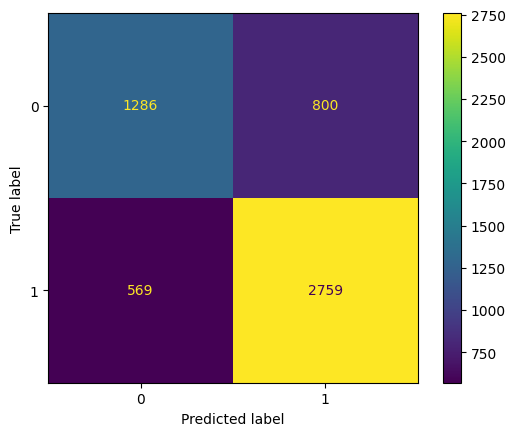

In [84]:
cm = confusion_matrix(y_test, y_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_classifier.classes_)
disp.plot()
plt.show()